In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import subprocess
import itertools

PATH='C:\\Users\\Robin_ULB\\Documents\\IBA_Work\\GitHub_IBA'
sys.path.append(PATH)
PATH='C:\\Users\\Robin_ULB\\Documents\\IBA_Work\\GitHub_IBA\\IBA-Optics'
sys.path.append(PATH)
import georges.physics as beamphys
import georges.plotting as beamplot
#import georges.plotting.histogram as beamhistoplot
#import georges.plotting.plot2Dprofile as__add_misalignment_element histo2D
from georges import Beamline
from georges import Beam
import georges.plotting as gplt
import georges.madx as gmadx
from pathlib import Path
import math

PATH_BL = "/home/rtesse/Documents/Work/GitHub/IBA-Optics/beamlines"



In [2]:
## PREPARE THE BEAMLINE AND LOAD THE BEAM
   
Brho=beamphys.energy_to_brho(228.15)
bl = Beamline('s2c2_extraction', elements='elements_cgtr', path=PATH_BL, prefix='generic')

bl.line.loc['Q1G','DELTAX'] = 0.01
bl.line.loc['Q1G','DELTAY'] = 0.1



  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.03.06  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2017.05.29               +
  + Execution date: 2017.08.10 17:05:24      +
  ++++++++++++++++++++++++++++++++++++++++++++

X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> X:> ++++++ info: ipmq redefined
X:> X:> X:> X:> X:> X:> X:> X:> X:> Assigned alignment errors to 6 elements
X:> X:> Replaced alignment errors for 6 elements
X:> X:> Replaced alignment errors for 6 elements
X:> X:> Replaced alignment errors for 6 elements
X:> X:> Replaced alignment errors for 6 elements
X:> X:> Replaced alignment errors for 6 elements
X:> X:> Replaced alignment errors for 6 elements
X:> X:> X:> X:>  MAD-X Beam Parameters
                  Energy : 0.116642E+01
          Kinetic Energy : 0.228150E+00
      Particle Rest Mass : 0.938272E+00
           

NAME
S2C2_OUT          0
BEAMLINE$START    0
S2C2              0
S2C2_IN           0
DRIFT_0           0
PMQ1_IN           0
PMQ1              0
PMQ1_OUT          0
DRIFT_1           0
PMQ2_IN           0
PMQ2              0
PMQ2_OUT          0
DRIFT_2           0
MARKA_OUT         0
MARKA_IN          0
MARKA             0
DRIFT_3           0
Q1C_IN            0
Q1C               0
Q1C_OUT           0
DRIFT_4           0
Q2C_IN            0
Q2C               0
Q2C_OUT           0
DRIFT_5           0
MARKB_IN          0
MARKB             0
MARKB_OUT         0
DRIFT_6           0
DEG               0
DEG_IN            0
DEG_OUT           0
DRIFT_7           0
Q1G_IN            0
Q1G               0
Q1G_OUT           0
DRIFT_8           0
Q2G_IN            0
Q2G               0
Q2G_OUT           0
DRIFT_9           0
DIVSLITS_IN       0
DIVSLITS          0
DIVSLITS_OUT      0
BEAMLINE$END      0
Name: X, dtype: int64


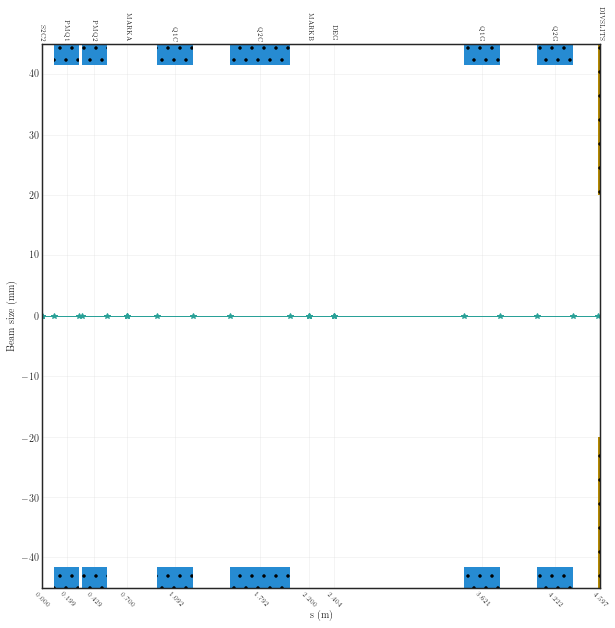

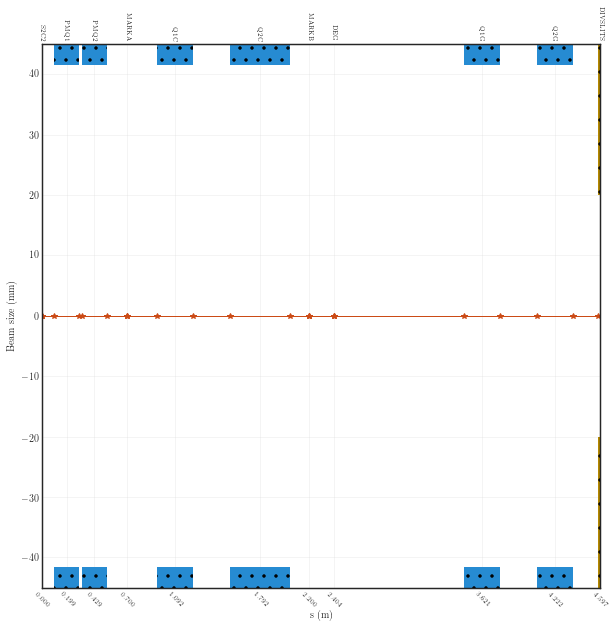

In [3]:
IPMQ=17.5
IQ1G=-12.745
IQ2G=9.1468
IQ1C=-17.84047648
IQ2C=14.95670807

Brho=beamphys.energy_to_brho(228.15)

beamS2C2 = pd.read_table('BeamS2C2.dat',skiprows=3,delimiter=' ',header=None)
beamS2C2.columns=['X','Y','Z','PX','PY','PZ','t','PDGid','EventID','TrackID','ParentID','Weight']
beamS2C2.drop(['Z','PZ','t','PDGid','EventID','TrackID','ParentID','Weight'], axis=1,inplace=True)
beamS2C2['DPP']=0.0

b = Beam(energy=228.15).from_5d_multigaussian_distribution(1,#len(beamS2C2),
                                               XRMS=0.000,
                                               PXRMS=0.00,
                                               YRMS=0.000,
                                               PYRMS=0.00,
                                               DPPRMS=0.00)

# b.distribution['X']=np.divide(beamS2C2['X'],1000)
# b.distribution['Y']=np.divide(beamS2C2['Y'],1000)
# b.distribution['PX']=np.divide(beamS2C2['PX'],1000*beamphys.energy_to_momentum(228.15))
# b.distribution['PY']=np.divide(beamS2C2['PY'],1000*beamphys.energy_to_momentum(228.15))

mad_context={
         'PARTICLE': 'PROTON',
         'PC': beamphys.energy_to_momentum(228.15),
         'IPMQ': IPMQ/Brho,
         'IQ1C': IQ1C/Brho,
         'IQ2C': IQ2C/Brho,
         'IQ1G': IQ1G/Brho,
         'IQ2G': IQ2G/Brho,
         'IQ':0.0
     }

c = {
        'BETAX': 0.0846155,
        'BETAY': 0.0846155,
        'ALPHAX': 0.0,
        'ALPHAY': 0.0,
        'DELTAP': 0.0,
        'DPP': 0.5e-2,
        'EMITX': 14.3e-6,
        'EMITY': 14.3e-6,
        'PARTICLE': 'PROTON',
         'PC': beamphys.energy_to_momentum(228.15),
         'IPMQ': IPMQ/Brho,
         'IQ1C': IQ1C/Brho,
         'IQ2C': IQ2C/Brho,
         'IQ1G': IQ1G/Brho,
         'IQ2G': IQ2G/Brho,
         'IQ':0.0
    }


bl_twiss = gmadx.twiss(line=bl.add_markers(), context=c, beam=b, debug=False)
bl_track = gmadx.track(line=bl.add_markers(), context=mad_context, beam=b, debug=True,ptc=True,fringe=False,misalignment=True)
    
# mad_mean=bl_track.line.loc['DEG','BEAM'].mean
# mad_std=bl_track.line.loc['DEG','BEAM'].std
# Particles=bl_track.line.loc['DEG','BEAM'].n_particles

print(bl_twiss.line['X'])
# print(bl_twiss.line.loc['PMQ1_IN','BEAM'].distribution)
# print(bl_twiss.line.loc['PMQ1_OUT','BEAM'].distribution)

with plt.style.context('seaborn-white'):
    fig = plt.figure(figsize=(10,10))
    fig2 = plt.figure(figsize=(10,10))
    
    ax = fig.add_subplot(111)
    gplt.prepare(ax, bl, size_arrows=False)
    gplt.aperture(ax, bl)
    gplt.tracking(ax, bl_track,plane='X',halo=False,std=False)
    
    
    ax2 = fig2.add_subplot(111)
    gplt.prepare(ax2, bl, size_arrows=False)
    gplt.aperture(ax2, bl)
    gplt.tracking(ax2, bl_track,plane='Y',halo=False,std=False)
    #gplt.twiss(ax2,bl_twiss,c,plane='Y')